## Init

In [1]:
# feffi module lives one level up current dir
import os
if not os.path.isdir('feffi'): #if not already in right place - hacky!
    os.chdir("../") #for feffi to work

import feffi
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np

## 2D constant linear x-wise left compression with structured mesh
Run 3 steps of the Lid Driven Cavity experiment, then compress the mesh x-wise with a factor of 0.9. Need to rebuild the bounding box tree as that is not automatically done and who knows why. Run an extra timestep then.

In [ ]:
feffi.parameters.define_parameters({
    'config_file' : 'feffi/config/lid-driven-cavity.yml',
})

mesh = feffi.mesh.create_mesh()
f_spaces = feffi.functions.define_function_spaces(mesh)
f = feffi.functions.define_functions(f_spaces)
domain = feffi.boundaries.Domain(mesh, f_spaces)
simul = feffi.simulation.Simulation(f, domain.BCs)
for i in range(3):
    simul.timestep()

# Compress mesh x-wise with factor 0.9
bmesh = BoundaryMesh(mesh, "exterior")
for x in bmesh.coordinates():
    x[0] *= 0.9
ALE.move(mesh, bmesh)
mesh.bounding_box_tree().build(mesh)

simul.timestep()

feffi.plot.plot_single(f['u_'], display=True)
feffi.plot.plot_single(mesh, display=True)

## 2D repeated linear x-wise left compression (structured mesh)
Repeatedly run 1 step of the Lid Driven Cavity experiment, then compress the mesh x-wise with a factor of 0.07 and  rebuild the bounding box tree.

In [ ]:
feffi.parameters.define_parameters({
    'config_file' : 'feffi/config/lid-driven-cavity.yml',
})

# Structured mesh
mesh = UnitSquareMesh(8,8)
feffi.plot.plot_single(mesh, display=True, title="Starting mesh")

f_spaces = feffi.functions.define_function_spaces(mesh)
f = feffi.functions.define_functions(f_spaces)
domain = feffi.boundaries.Domain(mesh, f_spaces)
simul = feffi.simulation.Simulation(f, domain.BCs)

# Repeatedly run 1 timestep and deform mesh
for x in range(10):
    print("\n\nMesh hmax is {}\n".format(mesh.hmax()))
    simul.timestep()

    # 0.02 x-wise displacement
    disp = Expression(("0.07*(left-x[0])", "0"),
                      left=max(mesh.coordinates()[:,0]), degree=2)
    ALE.move(mesh, disp)

    mesh.bounding_box_tree().build(mesh)

    feffi.plot.plot_single(f['u_'], display=True)
    feffi.plot.plot_single(mesh, display=True,
                           title="Mesh with left x = {}".format(min(mesh.coordinates()[:,0])))

## 2D repeated linear x-wise left compression (UNstructured mesh)
Repeatedly run 1 step of the Lid Driven Cavity experiment, then compress the mesh x-wise with a factor of 0.07 and  rebuild the bounding box tree.

In [ ]:
feffi.parameters.define_parameters({
    'config_file' : 'feffi/config/lid-driven-cavity.yml',
})

# Unstructured mesh
points = [Point(0,0), Point(1,0), Point(1,1), Point(0,1)] # square
#points = [Point(0,0), Point(10,0), Point(10,1), Point(0,1)] # long domain
domain = Polygon(points)
mesh = generate_mesh(domain, 16, 'cgal')

feffi.plot.plot_single(mesh, display=True, title="Starting mesh")

f_spaces = feffi.functions.define_function_spaces(mesh)
f = feffi.functions.define_functions(f_spaces)
domain = feffi.boundaries.Domain(mesh, f_spaces)
simul = feffi.simulation.Simulation(f, domain.BCs)

# Repeatedly run 1 timestep and deform mesh
for x in range(10):
    print("\n\nMesh hmax is {}\n".format(mesh.hmax()))
    simul.timestep()

    # 0.02 x-wise displacement
    disp = Expression(("0.07*(left-x[0])", "0"),
                      left=max(mesh.coordinates()[:,0]), degree=2)
    ALE.move(mesh, disp)

    mesh.bounding_box_tree().build(mesh)

    feffi.plot.plot_single(f['u_'], display=True)
    feffi.plot.plot_single(mesh, display=True,
                           title="Mesh with left x = {}".format(min(mesh.coordinates()[:,0])))

## 2D pointwise x-wise left compression (structured mesh)
- Run 1 step of the Lid Driven Cavity experiment.
- Store indexes of mesh points that belong to left boundary.
- Move left boundary points x-wise, each of a different random amount, and rebuild the bounding box tree.

In [ ]:
feffi.parameters.define_parameters({
    'config_file' : 'feffi/config/lid-driven-cavity.yml',
})

# Structured mesh
mesh = UnitSquareMesh(8,8)

feffi.plot.plot_single(mesh, display=True, title="Starting mesh")

f_spaces = feffi.functions.define_function_spaces(mesh)
f = feffi.functions.define_functions(f_spaces)
domain = feffi.boundaries.Domain(mesh, f_spaces)
simul = feffi.simulation.Simulation(f, domain.BCs)

# Get indexes of mesh points that belong to left boundary.
# Once we start moving them, this information is lost.
left_idxs = []
b_mesh = BoundaryMesh(mesh, 'exterior')
for p_idx in range(len(b_mesh.coordinates())):
    if domain.boundaries['left'].inside(b_mesh.coordinates()[p_idx], True):
        left_idxs.append(p_idx)

# Repeatedly run 1 timestep and deform mesh
for x in range(2):
    print("\n\nMesh hmax is {}\n".format(mesh.hmax()))
    simul.timestep()

    import random
    b_mesh = BoundaryMesh(mesh, 'exterior')
    for p_idx in left_idxs:
        b_mesh.coordinates()[p_idx][0] += (-1)**int(random.random()*10) * random.random()/10
        ALE.move(mesh, b_mesh)

    mesh.bounding_box_tree().build(mesh)

    feffi.plot.plot_single(f['u_'], display=True)
    feffi.plot.plot_single(mesh, display=True,
                           title="Mesh with left x = {}".format(min(mesh.coordinates()[:,0])))

## 2D x-wise left deformation wrt given points list (structured mesh)


[13:57:57] Plotting Starting mesh...


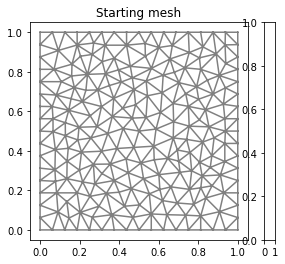

[13:57:57] BCs were only given for V, Q spaces.
[13:57:57] BCs - Boundary right, space V[0] (marker 1), value 0
[13:57:57] BCs - Boundary right, space V[1] (marker 1), value 0
[13:57:57] BCs - Boundary bottom, space V[0] (marker 3), value 0
[13:57:57] BCs - Boundary bottom, space V[1] (marker 3), value 0
[13:57:57] BCs - Boundary left, space V[0] (marker 2), value 0
[13:57:57] BCs - Boundary left, space V[1] (marker 2), value 0
[13:57:57] BCs - Boundary top, space V[0] (marker 4), value 1
[13:57:57] BCs - Boundary top, space V[1] (marker 4), value 0
[13:57:57] BCs - Point (0, 0), space Q, value 0
[13:57:57] Initialized simulation.
[13:57:57] Running parameters:
{'final_time': 10000000000, 'steps_n': 10, 'simulation_precision': -5, 'degree_V': 2, 'degree_P': 1, 'degree_T': 1, 'degree_S': 1, 'convert_from_ms_to_kmh': False, 'g': 0, 'nu': [0.01], 'alpha': [1], 'rho_0': 1, 'beta': 0, 'gamma': 0, 'T_0': 1, 'S_0': 35, 'Omega_0': '-5e-5', 'domain': 'square', 'domain_size_x': 2, 'domain_size_y

Current mesh left profile has 17 vertexes, perimeter 1.0 and coordinates 
 {3: array([0., 0.]), 5: array([0.    , 0.0625]), 49: array([0.   , 0.125]), 26: array([0.    , 0.1875]), 24: array([0.  , 0.25]), 25: array([0.    , 0.3125]), 56: array([0.   , 0.375]), 22: array([0.    , 0.4375]), 21: array([0. , 0.5]), 23: array([0.    , 0.5625]), 57: array([0.   , 0.625]), 34: array([0.    , 0.6875]), 33: array([0.  , 0.75]), 35: array([0.    , 0.8125]), 61: array([0.   , 0.875]), 1: array([0.    , 0.9375]), 0: array([0., 1.])}


Goal mesh left profile has 11 vertexes, perimeter 1.0398559323862417 and coordinates 
 [(0.024999999999999994, 0.0), (-0.01999999999999999, 0.1), (-0.05500000000000001, 0.2), (-0.08000000000000002, 0.30000000000000004), (-0.095, 0.4), (-0.1, 0.5), (-0.095, 0.6000000000000001), (-0.07999999999999999, 0.7000000000000001), (-0.05499999999999999, 0.8), (-0.01999999999999999, 0.9), (0.024999999999999994, 1.0)]


Mesh hmax is 0.11286713113727873



[13:57:57] Timestep 0 of 100000000000:
[13:57:57]   Non-linearity u-P solved in 5 steps.
[13:57:57]   ||u|| = 0.12222, ||u||_8 = 1.0, ||u-u_n|| = 0.12222, ||u-u_n||/||u|| = 1.0, div(u) = 1e-16
[13:57:57]   ||p|| = 0.1, ||p||_8 = 1.07524, ||p-p_n|| = 0.1, ||p-p_n||/||p|| = 1.0


KeyError: 4

In [32]:
feffi.parameters.define_parameters({
    'config_file' : 'feffi/config/lid-driven-cavity.yml',
})

# Unstructured mesh
points = [Point(0,0), Point(1,0), Point(1,1), Point(0,1)] # square
#points = [Point(0,0), Point(10,0), Point(10,1), Point(0,1)] # long domain
domain = Polygon(points)
mesh = generate_mesh(domain, 10, 'cgal')
feffi.plot.plot_single(mesh, display=True, title="Starting mesh")

f_spaces = feffi.functions.define_function_spaces(mesh)
f = feffi.functions.define_functions(f_spaces)
domain = feffi.boundaries.Domain(mesh, f_spaces)
simul = feffi.simulation.Simulation(f, domain.BCs)

# New "goal" left profile
step_size = 0.1
new_profile = [(0.5*(y-0.5)**2-0.1, y) 
         for y in np.arange(min(mesh.coordinates()[:,1]), 
                            max(mesh.coordinates()[:,1])+step_size, 
                            step_size)]

# Current left profile
left_points = {}
b_mesh = BoundaryMesh(mesh, 'exterior')
for p_idx in range(len(b_mesh.coordinates())):
    if domain.boundaries['left'].inside(b_mesh.coordinates()[p_idx], True):
        left_points[p_idx] = b_mesh.coordinates()[p_idx]
sorted_left_points = dict(sorted(left_points.items(), key=lambda dict_entry: dict_entry[1][1]))

def profile_length(profile):
    '''Naive curve length calculation with pythagorean theorem.'''
    
    profile_length = 0
    for i in range(1, len(profile)):
        profile_length += np.linalg.norm(np.subtract(profile[i], profile[i-1]))
    return profile_length

print(('Current mesh left profile has {} vertexes, perimeter {} and coordinates \n {}\n\n'
       .format(len(sorted_left_points), profile_length(list(sorted_left_points.values())), sorted_left_points)))
print(('Goal mesh left profile has {} vertexes, perimeter {} and coordinates \n {}'
       .format(len(new_profile), profile_length(new_profile), new_profile)))

import itertools

# Repeatedly run 1 timestep and deform mesh
total_steps = 1
for x in range(total_steps):
    print("\n\nMesh hmax is {}\n".format(mesh.hmax()))
    simul.timestep()

    b_mesh = BoundaryMesh(mesh, 'exterior')
    current_boundary_length = profile_length(list(sorted_left_points.values()))
    other_p_idx = 0
    cycle = itertools.cycle(list(sorted_left_points.items()))
    el = next(cycle) #ignore first
    
    for i in range(len(list(sorted_left_points.items()))):
        deform_coeff = (x+1)/total_steps
        
        curr_p_idx, curr_p_coord = el[0], el[1]
        el = next(cycle)
        next_p_idx, next_p_coord = el[0], el[1]
        
        d = np.linalg.norm(np.subtract(sorted_left_points[next_p_idx], sorted_left_points[curr_p_idx]))/current_boundary_length
        print(d)
        
        print(('old point {} becomes {}'
              .format(p_coord, 
                      (deform_coeff*new_profile[other_p_idx][0], 
                       deform_coeff*new_profile[other_p_idx][1]))))
        
        b_mesh.coordinates()[p_idx][0] = deform_coeff*new_profile[other_p_idx][0]
        b_mesh.coordinates()[p_idx][1] = deform_coeff*new_profile[other_p_idx][1]
        other_p_idx += 1
    print(b_mesh.coordinates())
    ALE.move(mesh, b_mesh)
    mesh.bounding_box_tree().build(mesh)

    feffi.plot.plot_single(f['u_'], display=True)
    feffi.plot.plot_single(mesh, display=True,
                           title="Mesh with left x = {}".format(min(mesh.coordinates()[:,0])))

## 3D

In [ ]:
feffi.parameters.define_parameters({
    'config_file' : 'feffi/config/lid-driven-cavity-3D.yml',
})

points = [(0,0), (4,0), (4.5,0.2), (5, 0.5), (5.5, 0.2), (6,0), (10,0), (10,1), (2,1), (2,0.8), (0, 0.8)]
Points = [Point(p) for p in points]
g2d = Polygon(Points)
m = generate_mesh(g2d, 20)
#g3d = mshr.Extrude2D(g2d, 1)
#m = mshr.generate_mesh(g2d, 70)
#m.coordinates()[:] = np.array([m.coordinates()[:, 0], m.coordinates()[:, 2], m.coordinates()[:, 1]]).transpose()
plot(m)
plt.show()

f_spaces = feffi.functions.define_function_spaces(m)
f = feffi.functions.define_functions(f_spaces)
domain = feffi.boundaries.Domain(mesh, f_spaces)
simul = feffi.simulation.Simulation(f, domain.BCs)
#simul.run()
for i in range(50):
    simul.timestep()
    if i % 10 == 0:
        feffi.plot.plot_solutions(f, display=True)